<a href="https://colab.research.google.com/github/riotamoriya/kaggle/blob/main/houseprices20211118.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
from pathlib import Path
%matplotlib inline

if 'google.colab' in sys.modules:  # colab環境
    INPUT = Path('/content/input/')
elif 'kaggle_web_client' in sys.modules:  # kaggle環境
    INPUT = Path('../input/')


from requests import get

name_notebook = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
print(name_notebook)


from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_emwa/kaggle.json ~/.kaggle
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle competitions list

In [10]:
tryone = 'house-prices-advanced-regression-techniques'

tryone = tryone + '.zip'
!kaggle competitions download -c house-prices-advanced-regression-techniques
import zipfile
with zipfile.ZipFile(tryone) as existing_zip:
    existing_zip.extractall('.')

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 62.5MB/s]


In [42]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

In [12]:



# 学習データ、テストデータの読み込み
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [45]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

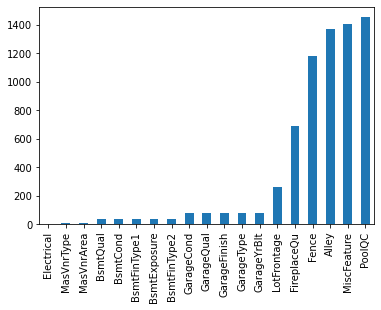

In [34]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

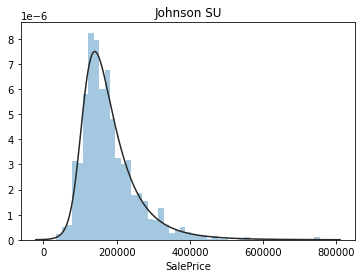

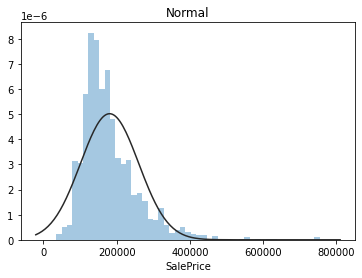

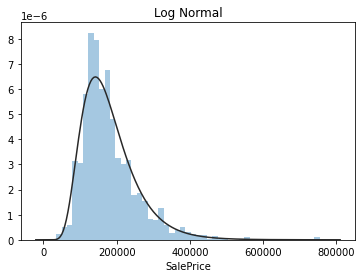

In [43]:
import scipy.stats as st
import matplotlib.pyplot as plt

y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)

plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)

plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

In [52]:
stats.shapiro(x.fillna(0))

NameError: ignored

In [54]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

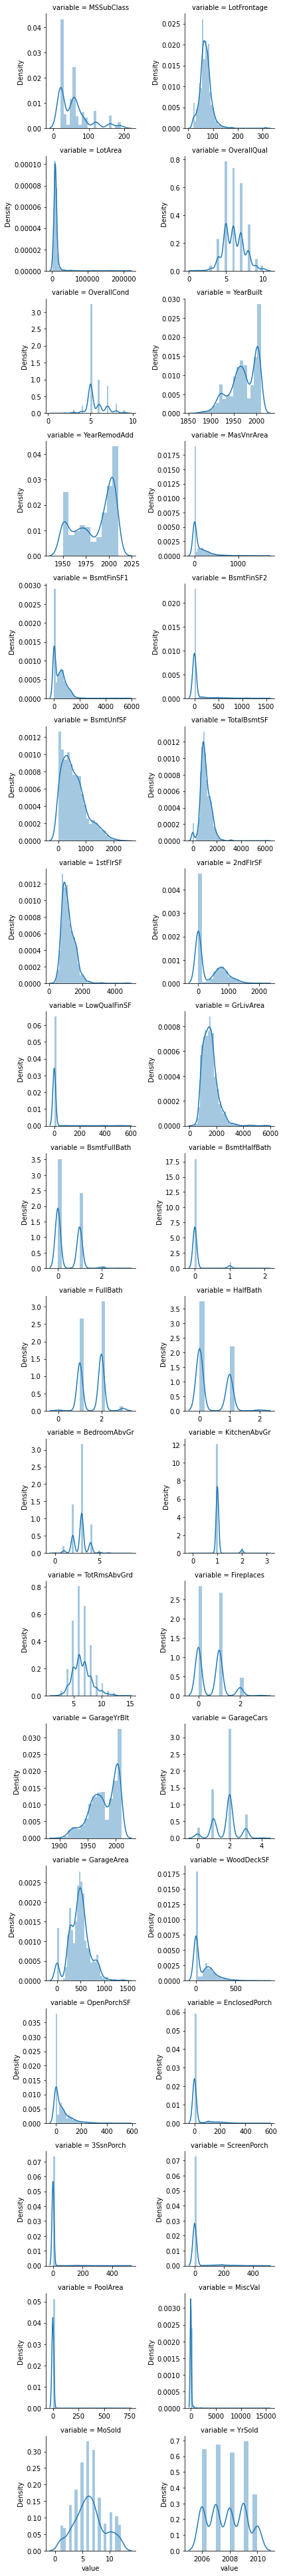

In [56]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


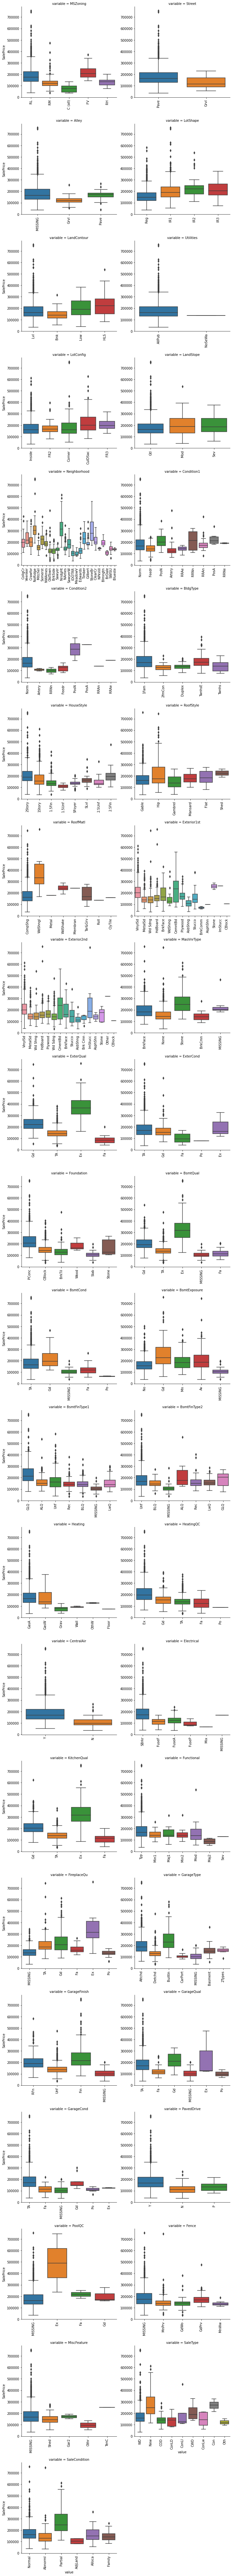

In [57]:
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")